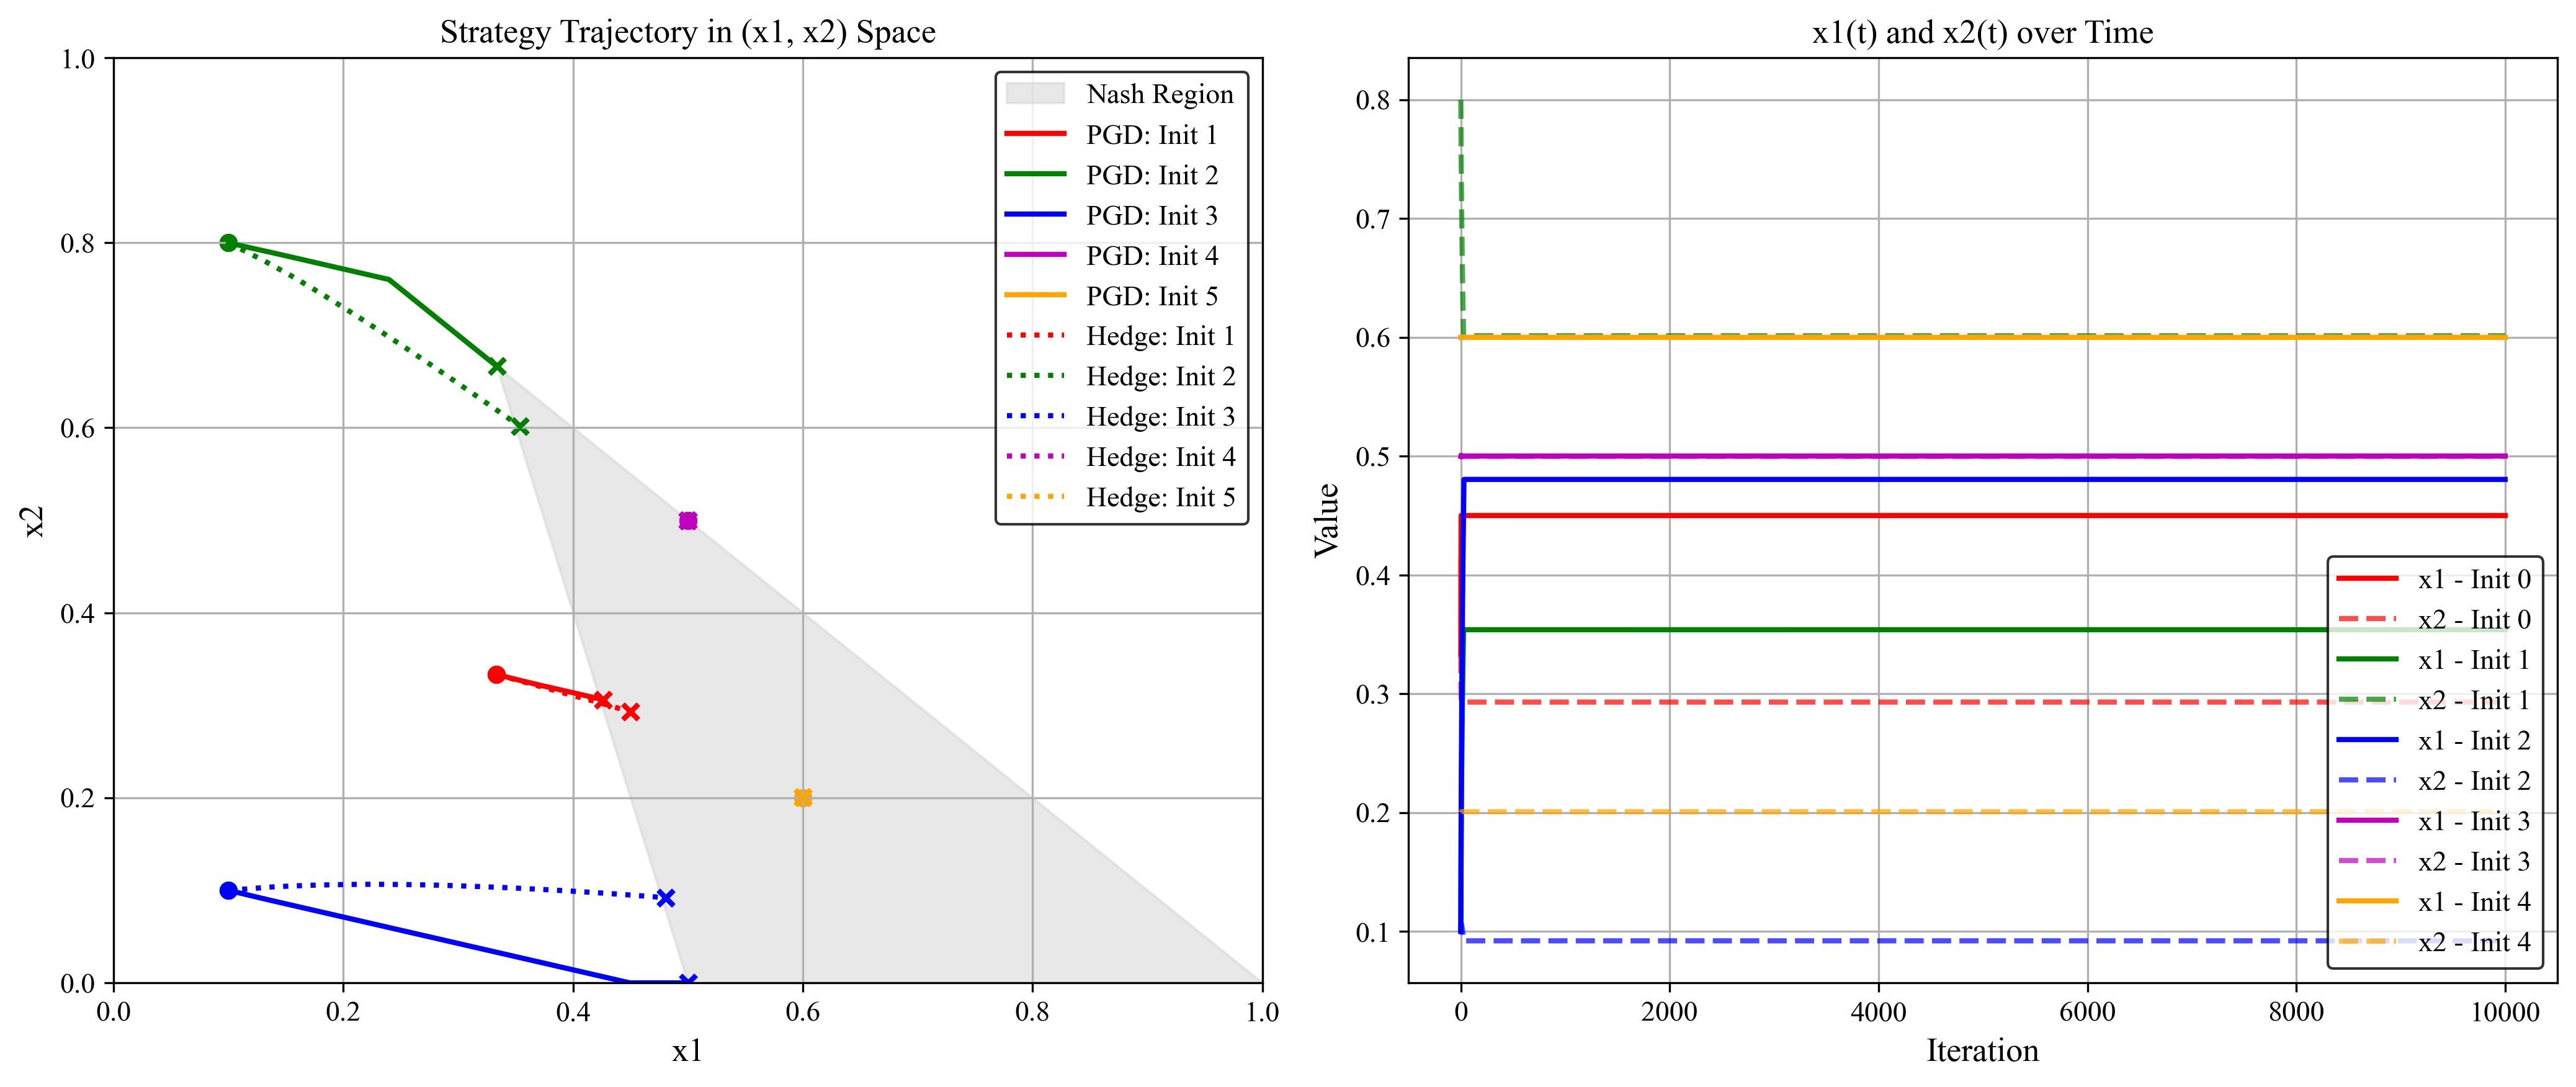

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange

def project_to_simplex(y):
    n = len(y)
    u = np.sort(y)[::-1]
    cumsum_u = np.cumsum(u)
    k = np.max(np.where(u > (cumsum_u - 1) / (np.arange(1, n + 1)))[0]) + 1
    theta = (cumsum_u[k - 1] - 1) / k
    return np.maximum(y - theta, 0)

def md_br_dynamics(x0, A, eps, num_iter, rate, lr_pbr, lr_hbr):
    xt_pbr = x0.copy()
    xts_pbr = [xt_pbr.copy()]
    xt_hbr = x0.copy()
    xts_hbr = [xt_hbr.copy()]
    
    V_PBR = []
    V_HBR = []

    for t in range(num_iter):
        noise = np.random.uniform(-0.1 / ((t+1)**eps), 0.1 / ((t+1)**eps), A.shape)
        At = A + noise

        yt_pbr_idx = np.argmax(xt_pbr @ At)
        yt_pbr = indx_mat[:, yt_pbr_idx]
        yt_hbr_idx = np.argmax(xt_hbr @ At)
        yt_hbr = indx_mat[:, yt_hbr_idx]

        V_PBR.append(np.max(xt_pbr @ At) - 1)
        V_HBR.append(np.max(xt_hbr @ At) - 1)

        grad = At @ yt_pbr
        eta_t = lr_pbr / ((t+1)**rate)
        xt_pbr = project_to_simplex(xt_pbr - eta_t * grad)
        xts_pbr.append(xt_pbr.copy())

        # Hedge+BR
        grad = At @ yt_hbr
        eta_t = lr_hbr / ((t+1)**rate)
        xt_hbr = xt_hbr * np.exp(-eta_t * grad)
        xt_hbr /= sum(xt_hbr)
        xts_hbr.append(xt_hbr.copy())

    return np.array(xts_pbr), V_PBR, np.array(xts_hbr), V_HBR

def plot_trajectories(trajectories_pbr, trajectories_hbr, labels=None):

    plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2,
    "legend.frameon": True,
    "legend.edgecolor": 'black',
    "figure.dpi": 300
    })
    
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111)

    x1 = np.linspace(0, 1, 1000)
    y_upper = 1 - x1
    y_lower = np.maximum(0, 2 - 4 * x1)

    plt.fill_between(x1, y_lower, y_upper, where=(y_upper >= y_lower), color='lightgray', alpha=0.5, label="Nash Region")

    colors = ['r', 'g', 'b', 'm', 'orange', 'cyan']

    for i, xts in enumerate(trajectories_pbr):
        x1_vals = xts[:, 0]
        x2_vals = xts[:, 1]
        plt.plot(x1_vals, x2_vals, '-', color=colors[i % len(colors)], label=labels[i] if labels else f'PGD: Init {i+1}')
        plt.scatter(x1_vals[0], x2_vals[0], color=colors[i % len(colors)], marker='o')  # 起点
        plt.scatter(x1_vals[-1], x2_vals[-1], color=colors[i % len(colors)], marker='x')  # 终点

    for i, xts in enumerate(trajectories_hbr):
        x1_vals = xts[:, 0]
        x2_vals = xts[:, 1]
        plt.plot(x1_vals, x2_vals, ':', color=colors[i % len(colors)], label=labels[i] if labels else f'Hedge: Init {i+1}')
        plt.scatter(x1_vals[0], x2_vals[0], color=colors[i % len(colors)], marker='o')  # 起点
        plt.scatter(x1_vals[-1], x2_vals[-1], color=colors[i % len(colors)], marker='x')  # 终点

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('MD+BR Strategy Evolution')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

np.random.seed(42)

A = np.array([
    [-1, 1],
    [2, 1],
    [3, 1]
])
eps = 1
lr_pbr = 0.01
lr_hbr = 0.1
rate = 0.8
T = 10000


indx_mat = np.eye(2)


initial_strategies = [
    np.array([1/3, 1/3, 1/3]),
    np.array([0.1, 0.8, 0.1]),
    np.array([0.1, 0.1, 0.8]),
    np.array([0.5, 0.5, 0.0]),
    np.array([0.6, 0.2, 0.2])
]

trajectories_pbr = []
trajectories_hbr = []
values_pbr = []
values_hbr = []
for x0 in initial_strategies:
    xts_pbr, V_pbr, xts_hbr, V_hbr = md_br_dynamics(x0, A, eps, T, rate, lr_pbr, lr_hbr)
    trajectories_pbr.append(xts_pbr)
    trajectories_hbr.append(xts_hbr)
    values_pbr.append(V_pbr)
    values_hbr.append(V_hbr)

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2,
    "legend.frameon": True,
    "legend.edgecolor": 'black',
    "figure.dpi": 300
})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1, ax2 = axes

x1 = np.linspace(0, 1, 200)
y_upper = 1 - x1
y_lower = np.maximum(0, 2 - 4 * x1)
ax1.fill_between(x1, y_lower, y_upper, where=(y_upper >= y_lower), color='lightgray', alpha=0.5, label="Nash Region")

colors = ['r', 'g', 'b', 'm', 'orange', 'cyan']

for i, xts in enumerate(trajectories_pbr):
    x1_vals = xts[:, 0]
    x2_vals = xts[:, 1]
    ax1.plot(x1_vals, x2_vals, '-', color=colors[i % len(colors)], label=f'PGD: Init {i+1}')
    ax1.scatter(x1_vals[0], x2_vals[0], color=colors[i % len(colors)], marker='o')  # 起点
    ax1.scatter(x1_vals[-1], x2_vals[-1], color=colors[i % len(colors)], marker='x')  # 终点

for i, xts in enumerate(trajectories_hbr):
    x1_vals = xts[:, 0]
    x2_vals = xts[:, 1]
    ax1.plot(x1_vals, x2_vals, ':', color=colors[i % len(colors)], label=f'Hedge: Init {i+1}')
    ax1.scatter(x1_vals[0], x2_vals[0], color=colors[i % len(colors)], marker='o')  # 起点
    ax1.scatter(x1_vals[-1], x2_vals[-1], color=colors[i % len(colors)], marker='x')  # 终点

ax1.set_title("Strategy Trajectory in (x1, x2) Space")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.grid(True)
ax1.legend()

for i in range(len(trajectories_pbr)):
    xts = trajectories_hbr[i]
    x1_vals, x2_vals = xts[:, 0], xts[:, 1]
    timesteps = np.arange(len(x1_vals))

    ax2.plot(timesteps, x1_vals, color=colors[i % len(colors)], linestyle='-', label=f'x1 - Init {i}')
    ax2.plot(timesteps, x2_vals, color=colors[i % len(colors)], linestyle='--', label=f'x2 - Init {i}', alpha=0.7)

ax2.set_title("x1(t) and x2(t) over Time")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Value")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.savefig("to_one_point_verify.pdf", bbox_inches="tight")
plt.show()

